In [ ]:
import gzip
import json
import pandas as pd
from sklearn import preprocessing
import numpy as np
import re
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
titles = pd.read_csv("/content/drive/MyDrive/book_title_cleaned_reviews.csv")
titles.head()

,Unnamed: 0,book_id,title,ratings,average_rating,genre,mod_title,n_votes,review_text
0,0,1333909,Good Harbor,10,3.23,fiction,good harbor,0,reviewers havent say mediocre cliches decent r...
1,1,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",140,4.03,fantasy,the unschooled wizard sun wolf and starhawk 12,1,competent sure read half years funniest twosto...
2,2,6066819,Best Friends Forever,51184,3.49,fiction,best friends forever,13,okay guy know love jennifer weiner go probably...
3,3,287140,Runic Astrology: Starcraft and Timekeeping in ...,15,3.40,nonfiction,runic astrology starcraft and timekeeping in t...,0,enjoy book rune student half decades enjoy dif...
4,4,287141,The Aeneid for Boys and Girls,46,4.13,fantasy,the aeneid for boys and girls,0,kid love book ancient history


In [ ]:
titles.dropna(inplace=True)

# Creating a binary variable for classification
titles["rated"] = 0
titles.loc[titles['average_rating'] < 4, 'rated'] = 0 ## Not so good books
titles.loc[titles['average_rating']>=4, 'rated'] = 1 ## Good Books
# train.loc[(train['average_rating']>=3.5) & (train['average_rating']<4), 'rated'] = 1 
# train.loc[(train['average_rating']>=4) & (train['average_rating']<4.5), 'rated'] = 2 
titles.head()

,Unnamed: 0,book_id,title,ratings,average_rating,genre,mod_title,n_votes,review_text,rated
0,0,1333909,Good Harbor,10,3.23,fiction,good harbor,0,reviewers havent say mediocre cliches decent r...,0
1,1,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",140,4.03,fantasy,the unschooled wizard sun wolf and starhawk 12,1,competent sure read half years funniest twosto...,1
2,2,6066819,Best Friends Forever,51184,3.49,fiction,best friends forever,13,okay guy know love jennifer weiner go probably...,0
3,3,287140,Runic Astrology: Starcraft and Timekeeping in ...,15,3.40,nonfiction,runic astrology starcraft and timekeeping in t...,0,enjoy book rune student half decades enjoy dif...,0
4,4,287141,The Aeneid for Boys and Girls,46,4.13,fantasy,the aeneid for boys and girls,0,kid love book ancient history,1


In [ ]:
# Split the data in training, validation and test
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error, max_error
from xgboost import XGBRegressor, XGBClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
train, test = train_test_split(titles[['mod_title', 'genre', 'n_votes', 'review_text', 'ratings', 'average_rating', 'rated']], test_size=0.30, random_state=42, stratify=titles['rated'])
test, valid = train_test_split(test, test_size=0.33, random_state=42, stratify=test['rated'])
print(train.shape)
print(test.shape)
print(valid.shape)

(952718, 7)
(273566, 7)
(134742, 7)


In [ ]:
column_trans = ColumnTransformer(
     [('categories', OneHotEncoder(dtype='int'), ['genre']),
      ('title_tfidf', TfidfVectorizer(), 'mod_title'),
      ('review_text_tfidf', TfidfVectorizer(), 'review_text')],
     remainder='passthrough')
column_trans.fit(train[['genre', 'mod_title', 'review_text', 'n_votes', 'ratings']])
transformed_train = column_trans.transform(train[['genre', 'mod_title', 'review_text', 'n_votes', 'ratings']])
transformed_valid = column_trans.transform(valid[['genre', 'mod_title', 'review_text', 'n_votes', 'ratings']])
transformed_test = column_trans.transform(test[['genre', 'mod_title', 'review_text', 'n_votes', 'ratings']])

In [ ]:
# from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

In [ ]:
standardized_train_sparse = csr_matrix(transformed_train)
standardized_valid_sparse = csr_matrix(transformed_valid)
standardized_test_sparse = csr_matrix(transformed_test)

# tsvd = TruncatedSVD(n_components=50)

# model_data = tsvd.fit(standardized_train_sparse).transform(standardized_train_sparse)
# print(tsvd.explained_variance_ratio_)
# valid_data = tsvd.transform(standardized_valid_sparse)
# test_data = tsvd.transform(standardized_test_sparse)

**Linear Regression**

In [ ]:
lr_model = LinearRegression().fit(standardized_train_sparse, train['average_rating'])

In [ ]:
## Training scores
preds = lr_model.predict(standardized_train_sparse)
print(r2_score(train['average_rating'], preds))
print(explained_variance_score(train['average_rating'], preds))
print(mean_absolute_error(train['average_rating'], preds))
print(mean_squared_error(train['average_rating'], preds))
print(max_error(train['average_rating'], preds))

0.4919932343005916
0.4919932343005915
0.19001102720774327
0.06404705229900183
2.474456610626442


In [ ]:
## Validation scores
preds = lr_model.predict(standardized_valid_sparse)
print(r2_score(valid['average_rating'], preds))
print(explained_variance_score(valid['average_rating'], preds))
print(mean_absolute_error(valid['average_rating'], preds))
print(mean_squared_error(valid['average_rating'], preds))
print(max_error(valid['average_rating'], preds))

0.19748325020031576
0.19749510734105358
0.24132474649745222
0.10184193335473701
2.513208404035402


In [ ]:
preds = lr_model.predict(standardized_test_sparse)
print(r2_score(test['average_rating'], preds))
print(explained_variance_score(test['average_rating'], preds))
print(mean_absolute_error(test['average_rating'], preds))
print(mean_squared_error(test['average_rating'], preds))
print(max_error(test['average_rating'], preds))

0.1954008510841061
0.19542451821292173
0.24110885243355068
0.10143105824795338
2.814875844938451


**Lasso Regression**

In [ ]:
lasso_model = Lasso(alpha=0.1, selection='random', normalize=True)
lasso_model.fit(standardized_train_sparse, train['average_rating'])

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Lasso(alpha=0.1, normalize=True, selection='random')

In [ ]:
preds = lasso_model.predict(standardized_train_sparse)
print(r2_score(train['average_rating'], preds))
print(explained_variance_score(train['average_rating'], preds))
print(mean_absolute_error(train['average_rating'], preds))
print(mean_squared_error(train['average_rating'], preds))
print(max_error(train['average_rating'], preds))

0.0
0.0
0.27508092459212075
0.1260751954963115
2.880527994642696


In [ ]:
preds = lasso_model.predict(standardized_valid_sparse)
print(r2_score(valid['average_rating'], preds))
print(explained_variance_score(valid['average_rating'], preds))
print(mean_absolute_error(valid['average_rating'], preds))
print(mean_squared_error(valid['average_rating'], preds))
print(max_error(valid['average_rating'], preds))

-5.868079355764166e-09
-2.220446049250313e-16
0.27572364628433366
0.12690318797429995
2.590527994642696


In [ ]:
preds = lasso_model.predict(standardized_test_sparse)
print(r2_score(test['average_rating'], preds))
print(explained_variance_score(test['average_rating'], preds))
print(mean_absolute_error(test['average_rating'], preds))
print(mean_squared_error(test['average_rating'], preds))
print(max_error(test['average_rating'], preds))

-1.0562879151354565e-05
2.220446049250313e-16
0.27506295884230936
0.12606542001521148
2.880527994642696


**Ridge Regression**

In [ ]:
ridge_model = Ridge(alpha=1, solver="sparse_cg", normalize=True)
ridge_model.fit(standardized_train_sparse, train['average_rating'])

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


Ridge(alpha=1, normalize=True, solver='sparse_cg')

In [ ]:
preds = ridge_model.predict(standardized_train_sparse)
print(r2_score(train['average_rating'], preds))
print(explained_variance_score(train['average_rating'], preds))
print(mean_absolute_error(train['average_rating'], preds))
print(mean_squared_error(train['average_rating'], preds))
print(max_error(train['average_rating'], preds))

0.6150309321103049
0.615030932110305
0.15105983817978952
0.04853505049422611
2.2991342018324983


In [ ]:
preds = ridge_model.predict(standardized_valid_sparse)
print(r2_score(valid['average_rating'], preds))
print(explained_variance_score(valid['average_rating'], preds))
print(mean_absolute_error(valid['average_rating'], preds))
print(mean_squared_error(valid['average_rating'], preds))
print(max_error(valid['average_rating'], preds))

0.20592574271685027
0.20595189971511896
0.2391785003120273
0.10077055414622656
2.4823836615174457


In [ ]:
preds = ridge_model.predict(standardized_test_sparse)
print(r2_score(test['average_rating'], preds))
print(explained_variance_score(test['average_rating'], preds))
print(mean_absolute_error(test['average_rating'], preds))
print(mean_squared_error(test['average_rating'], preds))
print(max_error(test['average_rating'], preds))

0.2014083036269977
0.2014482177375142
0.23930273558262255
0.1006737342194345
4.878566272113606


**Decision Tree**

In [ ]:
dt_model = DecisionTreeRegressor(max_depth=50, max_features=500, random_state=0)
dt_model.fit(standardized_train_sparse, train['average_rating'])

In [ ]:
preds = dt_model.predict(standardized_train_sparse)
print(r2_score(train['average_rating'], preds))
print(explained_variance_score(train['average_rating'], preds))
print(mean_absolute_error(train['average_rating'], preds))
print(mean_squared_error(train['average_rating'], preds))
print(max_error(train['average_rating'], preds))

In [ ]:
preds = dt_model.predict(standardized_valid_sparse)
print(r2_score(valid['average_rating'], preds))
print(explained_variance_score(valid['average_rating'], preds))
print(mean_absolute_error(valid['average_rating'], preds))
print(mean_squared_error(valid['average_rating'], preds))
print(max_error(valid['average_rating'], preds))

In [ ]:
preds = dt_model.predict(standardized_test_sparse)
print(r2_score(test['average_rating'], preds))
print(explained_variance_score(test['average_rating'], preds))
print(mean_absolute_error(test['average_rating'], preds))
print(mean_squared_error(test['average_rating'], preds))
print(max_error(test['average_rating'], preds))

**LightGBM Regressor**

In [ ]:
## Train the model
lgb_model = lgb.LGBMRegressor(n_estimators=500, n_jobs=-1, random_state=2)
lgb_model.fit(standardized_train_sparse, train['average_rating'])

LGBMRegressor(n_estimators=500, random_state=2)

In [ ]:
## Training scores
preds = lgb_model.predict(standardized_train_sparse)
print(r2_score(train['average_rating'], preds))
print(explained_variance_score(train['average_rating'], preds))
print(mean_absolute_error(train['average_rating'], preds))
print(mean_squared_error(train['average_rating'], preds))
print(max_error(train['average_rating'], preds))

0.236986627269277
0.2369866814725372
0.2380000259618433
0.09619706013332589
2.7582340217524846


In [ ]:
## Validation scores
preds = lgb_model.predict(standardized_valid_sparse)
print(r2_score(valid['average_rating'], preds))
print(explained_variance_score(valid['average_rating'], preds))
print(mean_absolute_error(valid['average_rating'], preds))
print(mean_squared_error(valid['average_rating'], preds))
print(max_error(valid['average_rating'], preds))

0.2135232421711336
0.2135242892059246
0.24188741339739486
0.09980640725050269
2.611744952236208


In [ ]:
preds = lgb_model.predict(standardized_test_sparse)
print(r2_score(test['average_rating'], preds))
print(explained_variance_score(test['average_rating'], preds))
print(mean_absolute_error(test['average_rating'], preds))
print(mean_squared_error(test['average_rating'], preds))
print(max_error(test['average_rating'], preds))

0.21149637006485367
0.21150654041747785
0.24164100418432644
0.09940199132007138
3.201227168609236


In [ ]:
import pickle
pickle.dump(lgb_model, open("lgb_rating_regressor.pkl", 'wb'))

(array([1.61000e+02, 1.39410e+04, 5.67034e+05, 3.71582e+05]),
 array([1, 2, 3, 4, 5]),
 <a list of 4 Patch objects>)

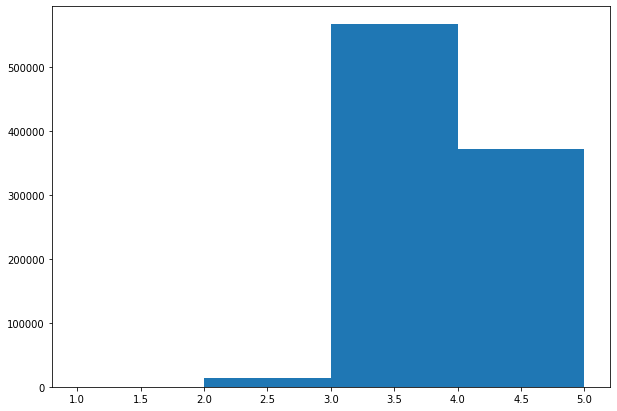

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(train['average_rating'], bins = [1, 2, 3, 4, 5])

In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, brier_score_loss
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def get_roc_curve(Yactual, Yprob, ModelName):
    '''Function to plot roc curve and find optimal threshold
    '''
    # calculate roc curves
    fpr, tpr, ths = roc_curve(Yactual, Yprob)
    
    # Finding the best threshold value
    gmeans = np.sqrt(tpr * (1-fpr))
    th_idx = np.argmax(gmeans)
    best_th = ths[th_idx]
    print(f'Best Threshold={best_th}, G-Mean={gmeans[th_idx]}')

    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='Random')
    plt.plot(fpr, tpr, marker='.', label=ModelName)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    return fpr, tpr, ths, best_th

def evaluate(Yactual, Ypred, Yprob=None):
    '''Function to calculate evaluation metrics
    '''
    if Yprob:
        print(f"Brier Score: {brier_score_loss(Yactual, Yprob)}")
        print(f"ROC AUC Score: {roc_auc_score(Yactual, Yprob)}")
    print(f"Balanced Accuracy Score: {balanced_accuracy_score(Yactual, Ypred)}")
    print(f"F1 Score: {f1_score(Yactual, Ypred)}")
    print(f"Precision Score: {precision_score(Yactual, Ypred)}")
    print(f"Recall Score: {recall_score(Yactual, Ypred)}")

def plot_confusion_mat(Cmat):
    '''Function to plot confusion matrix
    '''
    ax = sns.heatmap(Cmat, xticklabels='01', yticklabels='01', annot=True, square=True, cmap='Blues', fmt='g')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

**Logistic Regression**

Best Threshold=0.5008958641764232, G-Mean=0.5369647785950407


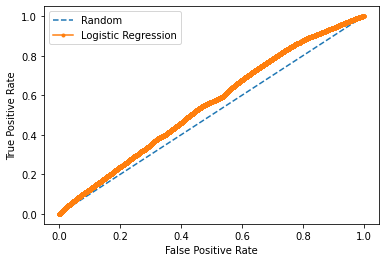

In [ ]:
logit_model = LogisticRegression(class_weight="balanced", random_state=2, n_jobs=-1)
logit_model.fit(standardized_train_sparse, train["rated"])
logit_prob = logit_model.predict_proba(standardized_valid_sparse)
cls_logit_prob = [i[1] for i in logit_prob]
fpr, tpr, ths, best_th = get_roc_curve(valid['rated'], cls_logit_prob, "Logistic Regression")

Brier Score: 0.25055880526576824
ROC AUC Score: 0.5524144031264991
Balanced Accuracy Score: 0.536969023419646
F1 Score: 0.47569155857784495
Precision Score: 0.4256268497513634
Recall Score: 0.5391041254376617


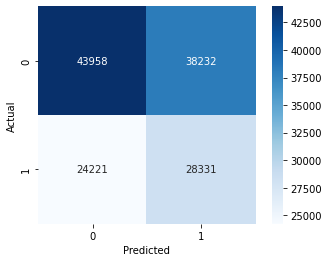

In [ ]:
logit_pred = (logit_prob >= best_th).astype(int)
logit_pred = [i[1] for i in logit_pred]
cmat = confusion_matrix(valid['rated'], logit_pred)
evaluate(valid['rated'], logit_pred, cls_logit_prob)
plot_confusion_mat(cmat)

Brier Score: 0.2506046173132568
ROC AUC Score: 0.5508670665917881
Balanced Accuracy Score: 0.5354836825731034
F1 Score: 0.4741098152727929
Precision Score: 0.42419697166057274
Recall Score: 0.5373349624039916


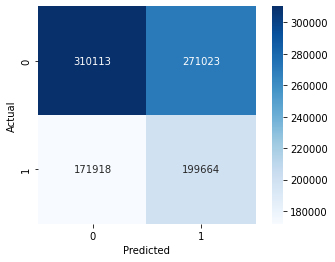

In [ ]:
logit_prob = logit_model.predict_proba(standardized_train_sparse)
cls_logit_prob = [i[1] for i in logit_prob]
logit_pred = (logit_prob >= best_th).astype(int)
logit_pred = [i[1] for i in logit_pred]
cmat = confusion_matrix(train['rated'], logit_pred)
evaluate(train['rated'], logit_pred, cls_logit_prob)
plot_confusion_mat(cmat)

Brier Score: 0.2506162086956343
ROC AUC Score: 0.5504140763444678
Balanced Accuracy Score: 0.5351193811729271
F1 Score: 0.4735498657532093
Precision Score: 0.42387907155870896
Recall Score: 0.536406834306494


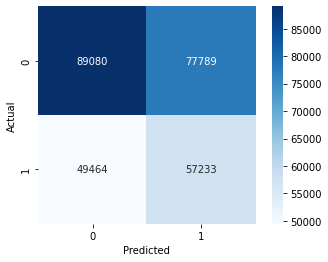

In [ ]:
logit_prob = logit_model.predict_proba(standardized_test_sparse)
cls_logit_prob = [i[1] for i in logit_prob]
logit_pred = (logit_prob >= best_th).astype(int)
logit_pred = [i[1] for i in logit_pred]
cmat = confusion_matrix(test['rated'], logit_pred)
evaluate(test['rated'], logit_pred, cls_logit_prob)
plot_confusion_mat(cmat)

**Decision Tree Classifier**

Best Threshold=0.4281237652765099, G-Mean=0.46377596463396503


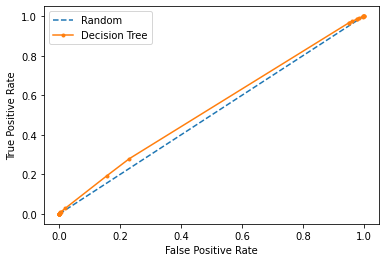

In [ ]:
dt_model = DecisionTreeClassifier(min_samples_split=20, max_features="auto", random_state=0)
dt_model.fit(standardized_train_sparse, train["rated"])
dt_prob = dt_model.predict_proba(standardized_valid_sparse)
cls_dt_prob = [i[1] for i in dt_prob]
fpr, tpr, ths, best_th = get_roc_curve(valid['rated'], cls_dt_prob, "Decision Tree")

Brier Score: 0.236783363827756
ROC AUC Score: 0.5300926257345003
Balanced Accuracy Score: 0.524678093798568
F1 Score: 0.340848929549993
Precision Score: 0.4371351995235259
Recall Score: 0.2793233368853707


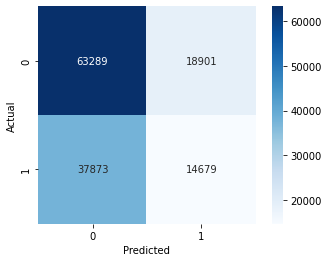

In [ ]:
dt_pred = (dt_prob >= best_th).astype(int)
dt_pred = [i[1] for i in dt_pred]
cmat = confusion_matrix(valid['rated'], dt_pred)
evaluate(valid['rated'], dt_pred, cls_dt_prob)
plot_confusion_mat(cmat)

Brier Score: 0.23667262751376772
ROC AUC Score: 0.5309456139262274
Balanced Accuracy Score: 0.5255571674867112
F1 Score: 0.3424276735752146
Precision Score: 0.43874049653501984
Recall Score: 0.28078862808209226


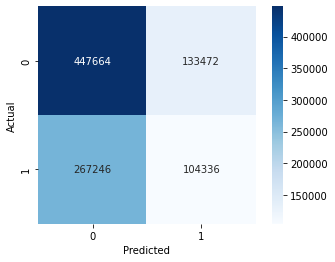

In [ ]:
dt_prob = dt_model.predict_proba(standardized_train_sparse)
cls_dt_prob = [i[1] for i in dt_prob]
dt_pred = (dt_prob >= best_th).astype(int)
dt_pred = [i[1] for i in dt_pred]
cmat = confusion_matrix(train['rated'], dt_pred)
evaluate(train['rated'], dt_pred, cls_dt_prob)
plot_confusion_mat(cmat)

Brier Score: 0.2506162086956343
ROC AUC Score: 0.5504140763444678
Balanced Accuracy Score: 0.5
F1 Score: 0.5611747658857159
Precision Score: 0.39002288296060184
Recall Score: 1.0


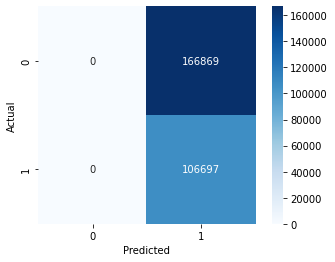

In [ ]:
dt_prob = dt_model.predict_proba(standardized_test_sparse)
cls_dt_prob = [i[1] for i in logit_prob]
dt_pred = (logit_prob >= best_th).astype(int)
dt_pred = [i[1] for i in dt_pred]
cmat = confusion_matrix(test['rated'], dt_pred)
evaluate(test['rated'], dt_pred, cls_dt_prob)
plot_confusion_mat(cmat)

**Random Forest Classifier**

Best Threshold=0.4990601124486249, G-Mean=0.6434028616492891


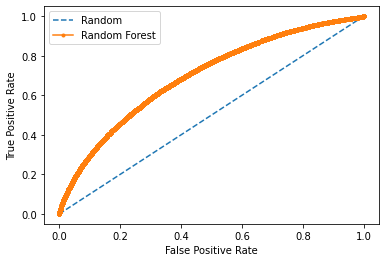

In [ ]:
rf_model = RandomForestClassifier(class_weight="balanced", n_estimators=500, max_leaf_nodes=31, n_jobs=-1, random_state=2)
rf_model.fit(standardized_train_sparse, train["rated"])
rf_prob = rf_model.predict_proba(standardized_valid_sparse)
cls_rf_prob = [i[1] for i in rf_prob]
fpr, tpr, ths, best_th = get_roc_curve(valid['rated'], cls_rf_prob, "Random Forest")

Brier Score: 0.2472929470278975
ROC AUC Score: 0.6967419334030134
Balanced Accuracy Score: 0.6437522646298631
F1 Score: 0.5800452107619343
Precision Score: 0.5429771131727881
Recall Score: 0.622545288476176


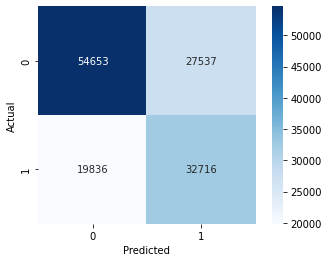

In [ ]:
rf_pred = (rf_prob >= best_th).astype(int)
rf_pred = [i[1] for i in rf_pred]
cmat = confusion_matrix(valid['rated'], rf_pred)
evaluate(valid['rated'], rf_pred, cls_rf_prob)
plot_confusion_mat(cmat)

Brier Score: 0.24721763776437378
ROC AUC Score: 0.7018758093461206
Balanced Accuracy Score: 0.6463335268893511
F1 Score: 0.5830506095428835
Precision Score: 0.5456251422083878
Recall Score: 0.6259883417388356


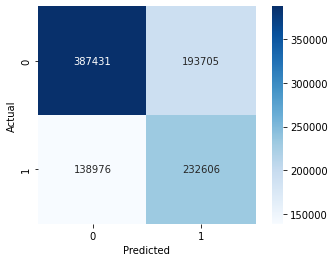

In [ ]:
rf_prob = rf_model.predict_proba(standardized_train_sparse)
cls_rf_prob = [i[1] for i in rf_prob]
rf_pred = (rf_prob >= best_th).astype(int)
rf_pred = [i[1] for i in rf_pred]
cmat = confusion_matrix(train['rated'], rf_pred)
evaluate(train['rated'], rf_pred, cls_rf_prob)
plot_confusion_mat(cmat)

Brier Score: 0.2506162086956343
ROC AUC Score: 0.5504140763444678
Balanced Accuracy Score: 0.49999324078017954
F1 Score: 0.5611655336550473
Precision Score: 0.3900196667617105
Recall Score: 0.9999625106610308


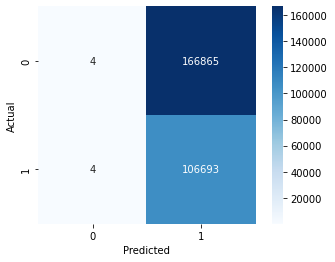

In [ ]:
rf_prob = rf_model.predict_proba(standardized_test_sparse)
cls_rf_prob = [i[1] for i in logit_prob]
rf_pred = (logit_prob >= best_th).astype(int)
rf_pred = [i[1] for i in rf_pred]
cmat = confusion_matrix(test['rated'], rf_pred)
evaluate(test['rated'], rf_pred, cls_rf_prob)
plot_confusion_mat(cmat)

**LightGBM Classifier**

Best Threshold=0.49340870743975174, G-Mean=0.6783373040222987


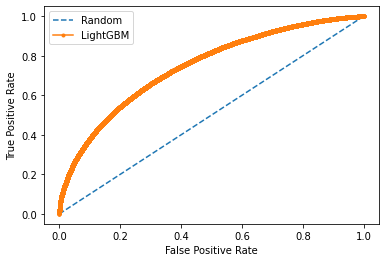

In [ ]:
lgb_model = lgb.LGBMClassifier(class_weight="balanced", n_estimators=500, n_jobs=-1, random_state=2)
lgb_model.fit(standardized_train_sparse, train["rated"])
lgb_prob = lgb_model.predict_proba(standardized_valid_sparse)
cls_lgb_prob = [i[1] for i in lgb_prob]
fpr, tpr, ths, best_th = get_roc_curve(valid['rated'], cls_lgb_prob, "LightGBM")

Brier Score: 0.20485798046954867
ROC AUC Score: 0.745671693269039
Balanced Accuracy Score: 0.6785237135953138
F1 Score: 0.6191183137906817
Precision Score: 0.5809766921934698
Recall Score: 0.6626198812604658


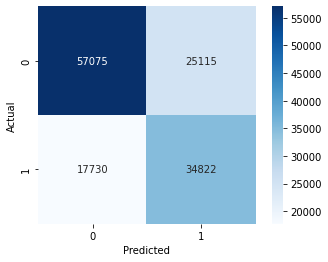

In [ ]:
lgb_pred = (lgb_prob >= best_th).astype(int)
lgb_pred = [i[1] for i in lgb_pred]
cmat = confusion_matrix(valid['rated'], lgb_pred)
evaluate(valid['rated'], lgb_pred, cls_lgb_prob)
plot_confusion_mat(cmat)

Brier Score: 0.20566016517851146
ROC AUC Score: 0.7424195741610038
Balanced Accuracy Score: 0.6760963849071646
F1 Score: 0.6163211323365827
Precision Score: 0.578453697233754
Recall Score: 0.6594937064772205


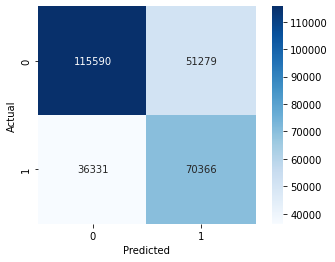

In [ ]:
lgb_prob = lgb_model.predict_proba(standardized_test_sparse)
cls_lgb_prob = [i[1] for i in lgb_prob]
lgb_pred = (lgb_prob >= best_th).astype(int)
lgb_pred = [i[1] for i in lgb_pred]
cmat = confusion_matrix(test['rated'], lgb_pred)
evaluate(test['rated'], lgb_pred, cls_lgb_prob)
plot_confusion_mat(cmat)

Brier Score: 0.20020774235617647
ROC AUC Score: 0.761520421072265
Balanced Accuracy Score: 0.6904974005636046
F1 Score: 0.6326450747504438
Precision Score: 0.5941095977822366
Recall Score: 0.6765263118235006


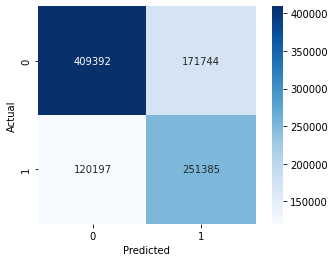

In [ ]:
lgb_prob = lgb_model.predict_proba(standardized_train_sparse)
cls_lgb_prob = [i[1] for i in lgb_prob]
lgb_pred = (lgb_prob >= best_th).astype(int)
lgb_pred = [i[1] for i in lgb_pred]
cmat = confusion_matrix(train['rated'], lgb_pred)
evaluate(train['rated'], lgb_pred, cls_lgb_prob)
plot_confusion_mat(cmat)

**Hyper Parameter Tuning for LightGBM Model**


In [ ]:
param_space = {'n_estimators': [50, 100, 250, 400, 500],
               'learning_rate': [0.001, 0.01, 0.1, 0.5, 0.9],
               'num_leaves': np.arange(10, 200, 20),
               }
lgb_model = lgb.LGBMClassifier(class_weight="balanced", random_state=2)
random_cv = RandomizedSearchCV(estimator=lgb_model,
                               param_distributions=param_space,
                               scoring='roc_auc',
                               n_iter=10, verbose=1)
random_cv.fit(standardized_train_sparse, train["rated"])
print("Best parameters:", random_cv.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [ ]:
# LGB_model with best parameters
lgb_model = lgb.LGBMClassifier(class_weight="balanced", n_jobs=-1, random_state=2)
lgb_model.set_params(**random_cv.best_params_)
lgb_model.fit(standardized_train_sparse, train["rated"])

In [ ]:
lgb_prob = lgb_model.predict_proba(standardized_valid_sparse)
cls_lgb_prob = [i[1] for i in lgb_prob]
fpr, tpr, ths, best_th = get_roc_curve(valid["rated"], cls_lgb_prob, "LightGBM")

In [ ]:
lgb_pred = (lgb_prob >= best_th).astype(int)
lgb_pred = [i[1] for i in lgb_pred]
cmat = confusion_matrix(valid["rated"], lgb_pred)
evaluate(valid["rated"], lgb_pred, cls_lgb_prob)
plot_confusion_mat(cmat)